# Neural Ordinary Differential Equation

Using a neural network to learn the derivative of a function from the inputs to the outputs, which is approximated by a numerical ordinary differential equation solver.  Chen et al (2018) showed how to backpropogate the gradient of the loss over the ODE solver by solving another ODE, using a method called the adjoint sensitivity method.  They've implemented ODE solvers in pytorch, and their basic methods allow regular backpropogation, but they've also implemented a method which uses the adjoint for backpropogation, which seems to be more numerically robust and only linear in the amount of memory used...  Might need to read more about it...  The regular method uses more memory but is faster for smaller problems.

Have to use pytorch nn Module for neural net.  Good to start learning it.

This is actually starting to seem retarded.  All you're doing is learning a function from the input to the difference between the input and the output, and then running a numerical solver over that, instead of just learning the mapping from the input directly to the output.  I really can't see how that would ever be beneficial.  So really this only makes sense when you're learning actual trajectories right?  Does it make sense then?  To learn the gradients of the trajectories, rather than the trajectories directly?  I guess if you expect the gradient to have a simpler form, and that sounds a lot more sensible.  Man, is Sally right that even these big conferences are just publishing rubbish because they're all rushing too much to even think about what they're doing???

In [5]:
# Import packages
import numpy as np
import torch
import plotly.graph_objects as go
from nn import *
import torchdiffeq
import torch.nn as nn
import torch.optim as optim

In [158]:
# Make data
r = 1
x = torch.linspace(-r, r, 101).reshape(101, 1)

# Target functions, from easy to hard
# y = torch.maximum(2 * x, torch.zeros_like(x))
# y = x**3
# y = np.exp(x)
y = np.sin(np.pi * x)

# Set number of neurons in hidden layer
n_hidden=10

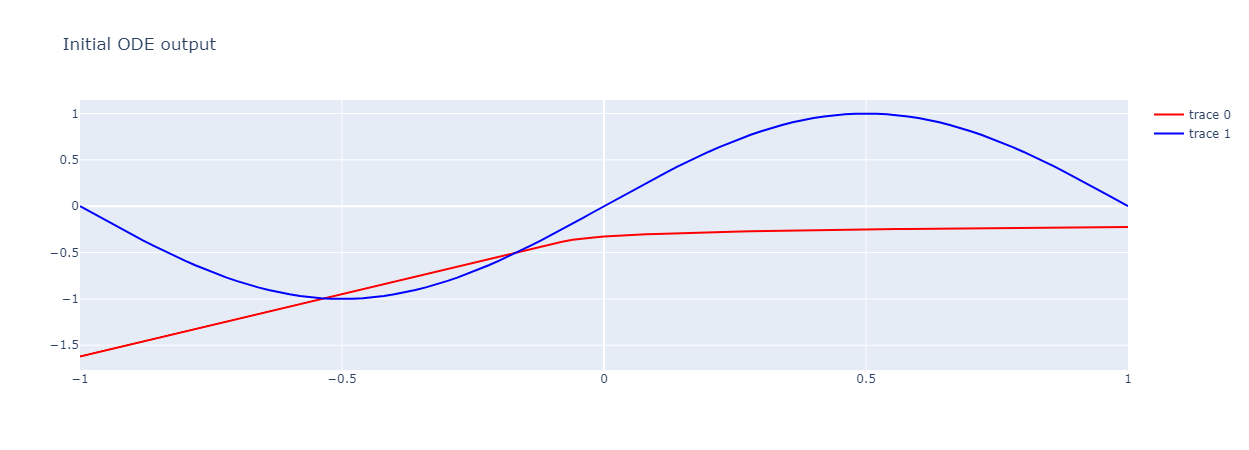

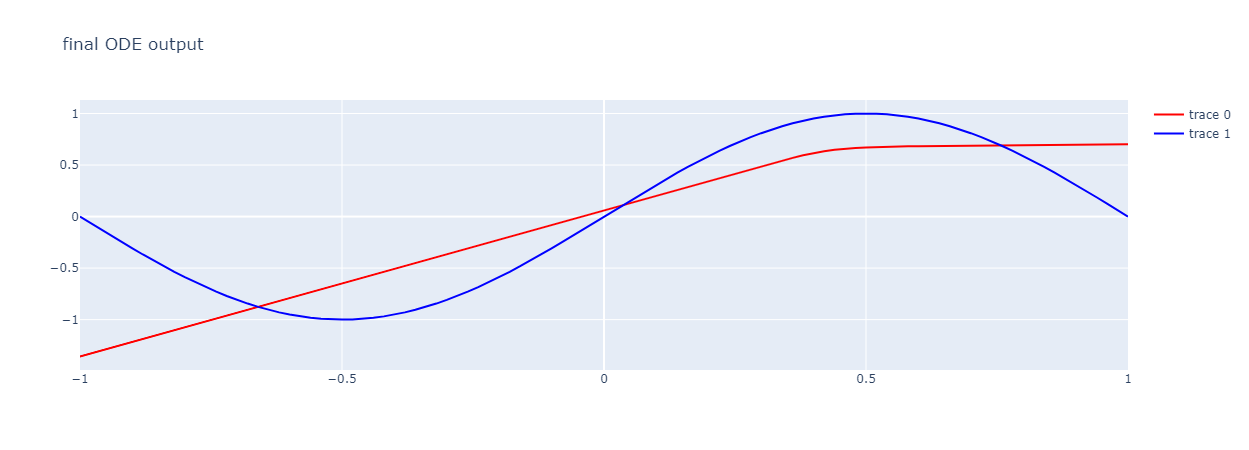

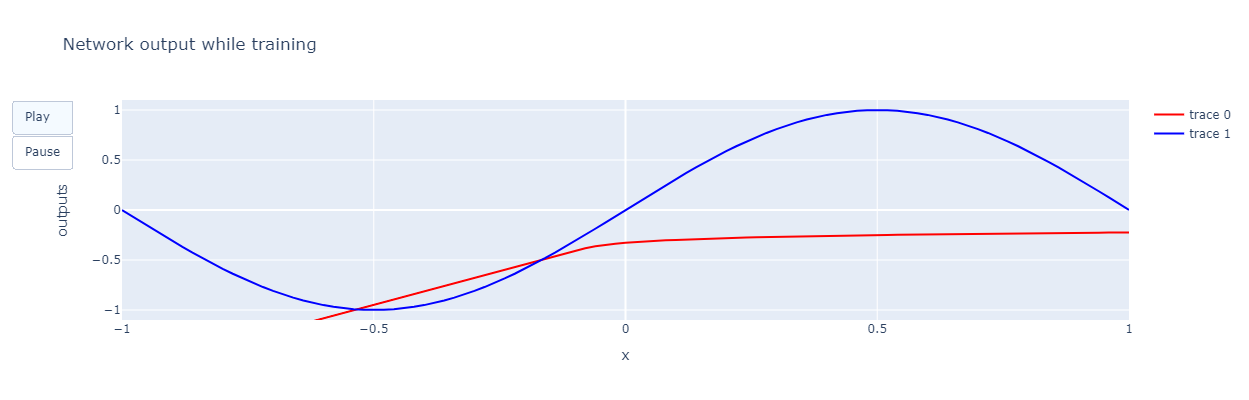

In [213]:
# Set parameters
batch_size = 101
niters = 50
test_freq = 5
adjoint = False
lr = 5e-3

# Import ODE integrator with or without adjoint method for backpropogating gradients
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

# Specify GPU if available, CPU otherwise
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Create batch of input-output pairs for now.
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(101, dtype=np.int64), batch_size, replace=False))
    batch_y0 = x[s]
    batch_t = torch.Tensor(np.arange(2))
    batch_y = torch.stack([x[s], y[s]], dim=0)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

# Neural net to learn function dynamics (required for adjoint method)
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 5),
            nn.ReLU(),
            nn.Linear(5, 1),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=1)
                nn.init.constant_(m.bias, val=0.1)

    def forward(self, t, y):
        return self.net(y)
    
# # Plot initial network output
# go.Figure(
#     go.Scatter(x=x[:, 0], y=ODEFunc()(x, x).detach()[:, 0], line_color='red'), 
#     dict(title="Initial network output")
# ).show()

# Pass function to GPU, attach optimiser
func = ODEFunc().to(device)
optimizer = optim.RMSprop(func.parameters(), lr=lr)

# Plot initial ODE output
t = torch.Tensor(np.arange(2)).to(device)
ode_out = odeint(func, x.to(device), t).cpu().detach().numpy()[1, :][:, 0]
data = [
    go.Scatter(x=x[:, 0], y=ode_out, line_color='red'), 
    go.Scatter(x=x[:, 0], y=y[:, 0], line_color='blue')
]
go.Figure(data, dict(title="Initial ODE output")).show()

data_list = [data]

# Loop over iterations of gradient descent for ODE solver and neural net
for itr in range(1,  niters + 1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = odeint(func, batch_y0, t).to(device)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    if itr %  test_freq == 1:
        with torch.no_grad():
            # Save ODE output for animation
            ode_out = odeint(func, x.to(device), t).cpu().detach().numpy()[1, :][:, 0]
            data_list = data_list + [[
                go.Scatter(x=x[:, 0], y=ode_out, line_color='red'), 
                go.Scatter(x=x[:, 0], y=y[:, 0], line_color='blue')
            ]]

# Plot final network output
# go.Figure(
#     go.Scatter(x=x[:, 0], y=ODEFunc()(x, x).detach()[:, 0], line_color='red'), 
#     dict(title="Final network output")
# ).show()

# Plot final ODE output
ode_out = odeint(func, x.to(device), t).cpu().detach().numpy()[1, :][:, 0]
data = [
    go.Scatter(x=x[:, 0], y=ode_out, line_color='red'), 
    go.Scatter(x=x[:, 0], y=y[:, 0], line_color='blue')
]
go.Figure(data, dict(title="final ODE output")).show()

data_list = data_list + [data]

plot_animation(y, data_list)

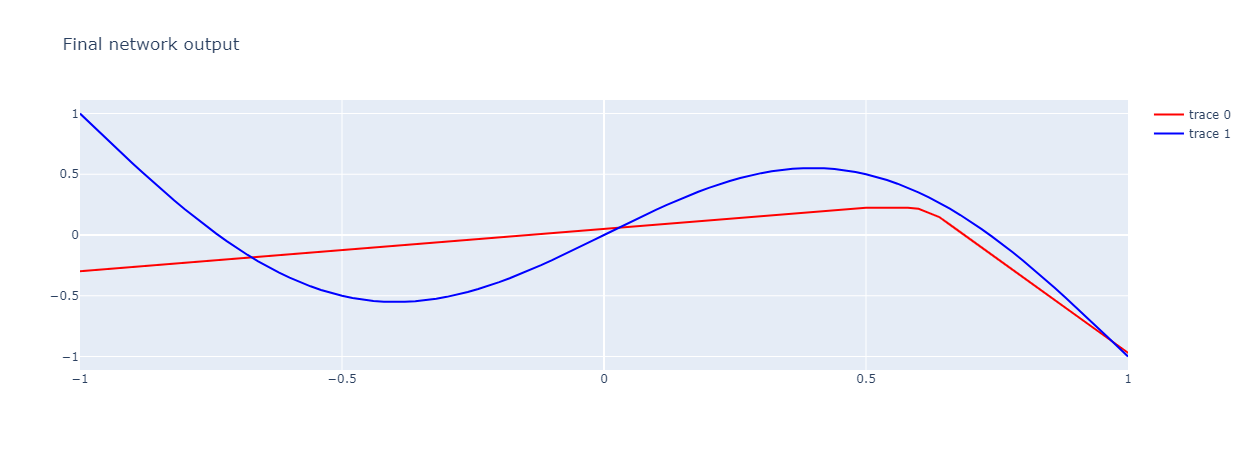

In [215]:
# Plot final network output
data = [go.Scatter(
    x=x[:, 0], y=func(0, x.to(device)).cpu().detach()[:, 0], line_color='red'
), go.Scatter(
    x=x[:, 0], y=y[:, 0] - x[:, 0], line_color='blue'
)]
go.Figure(data, dict(title="Final network output")).show()

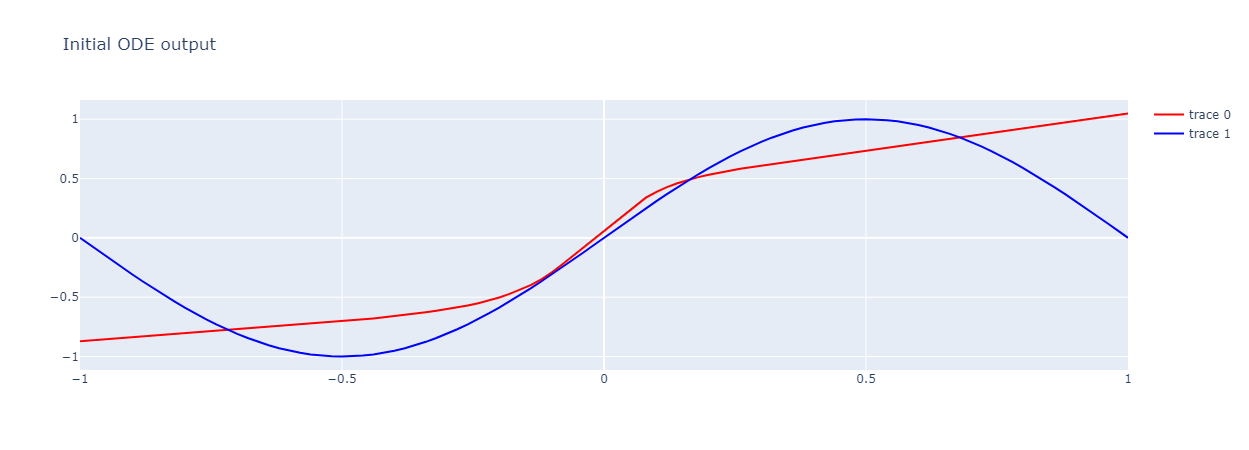

Iter 0001 | Total Loss 0.127320
Iter 0006 | Total Loss 0.182594
Iter 0011 | Total Loss 0.182485
Iter 0016 | Total Loss 0.182411
Iter 0021 | Total Loss 0.182419
Iter 0026 | Total Loss 0.182345
Iter 0031 | Total Loss 0.182310
Iter 0036 | Total Loss 0.182298
Iter 0041 | Total Loss 0.182281
Iter 0046 | Total Loss 0.182270


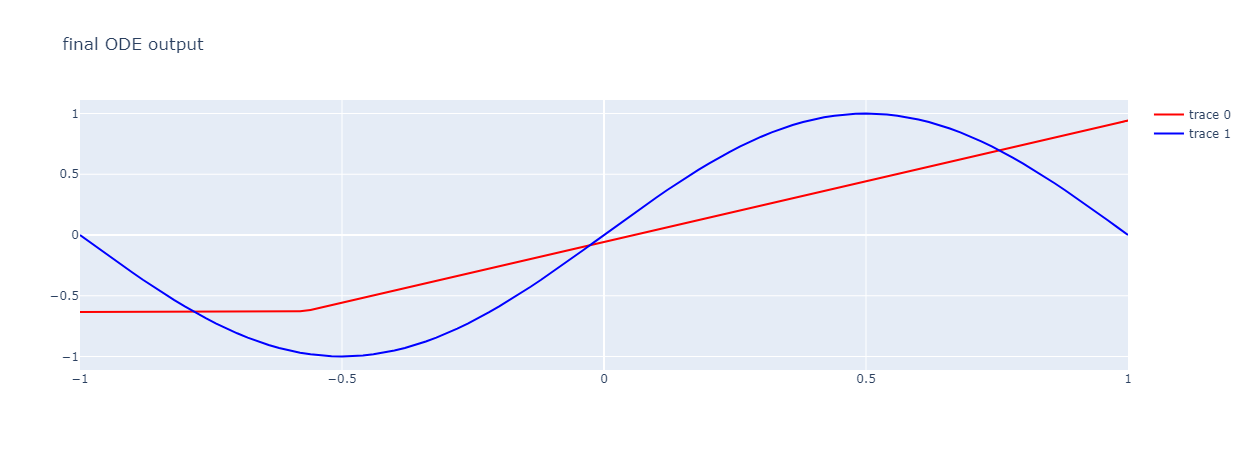

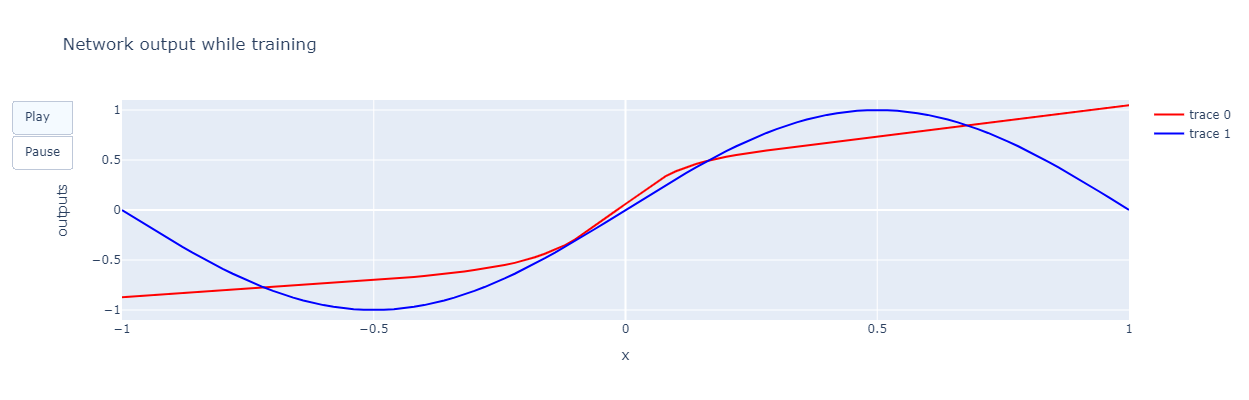

In [190]:
niter = 50

# Pass function to GPU, attach optimiser
# func = ODEFunc().to(device)
optimizer = optim.RMSprop(func.parameters(), lr=5e-2)

# Plot initial ODE output
t_gpu = torch.Tensor(np.arange(2)).to(device)
ode_out = odeint(func, x.to(device), t_gpu).cpu().detach().numpy()[1, :][:, 0]
data = [
    go.Scatter(x=x[:, 0], y=ode_out, line_color='red'), 
    go.Scatter(x=x[:, 0], y=y[:, 0], line_color='blue')
]
go.Figure(data, dict(title="Initial ODE output")).show()

data_list = [data]

# Loop over iterations using the differential equation solver (integrator) to
# predict the output using the neural network derivative function, getting the loss, and
# back-propogating the gradient through the ODE solver to the neural net - 
# that's all there is to it
for itr in range(1,  niters + 1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = odeint(func, batch_y0, batch_t).to(device)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    if itr %  test_freq == 1:
        with torch.no_grad():
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            
            # Plot current ODE output
            t_gpu = torch.Tensor(np.arange(2)).to(device)
            ode_out = odeint(func, x.to(device), t_gpu).cpu().detach().numpy()[1, :][:, 0]
            data_list = data_list + [[
                go.Scatter(x=x[:, 0], y=ode_out, line_color='red'), 
                go.Scatter(x=x[:, 0], y=y[:, 0], line_color='blue')
            ]]
#             go.Figure(data, dict(title="Current ODE output")).show()

# # Plot final network output
# data = [go.Scatter(
#     x=x[:, 0], y=ODEFunc()(torch.ones(1), torch.ones(1) * x).detach()[:, 0], line_color='red'
# ), go.Scatter(x=x[:, 0], y=y[:, 0], line_color='blue')]
# go.Figure(data, dict(title="Final network output")).show()

# Plot final ODE output
t_gpu = torch.Tensor(np.arange(2)).to(device)
ode_out = odeint(func, x.to(device), t_gpu).cpu().detach().numpy()[1, :][:, 0]
data = [
    go.Scatter(x=x[:, 0], y=ode_out, line_color='red'), 
    go.Scatter(x=x[:, 0], y=y[:, 0], line_color='blue')
]
go.Figure(data, dict(title="final ODE output")).show()

data_list = data_list + [data]

plot_animation(y, data_list)

In [20]:
for p in func.parameters():
    print(p)

Parameter containing:
tensor([[ 0.0360],
        [ 0.0932],
        [-0.0002],
        [-0.0511],
        [ 0.0030],
        [-0.1328],
        [ 0.1029],
        [-0.0220],
        [ 0.0090],
        [-0.1467]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[ 0.1250,  0.0673, -0.1814, -0.1801, -0.0358, -0.0132,  0.0345, -0.0736,
         -0.0263,  0.2047]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0.1000], device='cuda:0', requires_grad=True)


In [30]:
# Import libraries
import time
import torch.nn as nn
import torch.optim as optim

# Set parameters
method = 'dopri5'
data_size = 1000
batch_time = 10
batch_size = 20
niters = 100
test_freq = 20
gpu = 0
adjoint = True

# Import ODE integrator depending on whether adjoint is set to true
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

# Specify GPU if available, CPU otherwise
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')

# Initial (two-D) value, times for evaluation of solution, and a matrix 
# defining the spiral gradient
true_y0 = torch.tensor([[2., 0.]]).to(device)
t = torch.linspace(0., 25., data_size).to(device)
true_A = torch.tensor([[-0.1, 2.0], [-2.0, -0.1]]).to(device)

# Lambda class extending a neural network module by defining a function 
# forward that returns a matrix multiply of the cube of a vector y and a matrix A
class Lambda(nn.Module):
    def forward(self, t, y):
        return torch.mm(y**3, true_A)

# Find true solution to differential equation
with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, t, method='dopri5')

# Create batch of samples of initial values, times, and true trajectories
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[:batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

# Class extending nn module with a two-layer net, tanh on the hidden, 
# initialising the weights, and a forward function that takes the cube of y and
# passes it through the net.
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 2),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y**3)

# Pass function to GPU, attache optimiser
func = ODEFunc().to(device)
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)

# Loop over iterations using the differential equation solver (integrator) to
# predict the output from the neural network derivative function, getting the loss, and
# back-propogating the gradient through the ODE solver to the neural net - 
# that's all there is to it
for itr in range(1,  niters + 1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = odeint(func, batch_y0, batch_t).to(device)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    if itr %  test_freq == 0:
        with torch.no_grad():
            pred_y = odeint(func, true_y0, t)
            loss = torch.mean(torch.abs(pred_y - true_y))
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))

Iter 0020 | Total Loss 0.710318
Iter 0040 | Total Loss 0.554677
Iter 0060 | Total Loss 0.432260
Iter 0080 | Total Loss 0.738078
Iter 0100 | Total Loss 0.512062
